# **BC COVID-19 Cases Modeling**
            -- This is a project that is still in progress, will be adding recovered case modelling and explore other model to make better predictions
![](./Comparison.png)

In [1]:
import warnings

warnings.filterwarnings('ignore')
# libraries
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import adam_v2



In [2]:
# Data source
caseDetailsUrl = 'http://www.bccdc.ca/Health-Info-Site/Documents/BCCDC_COVID19_Dashboard_Case_Details.csv'

In [3]:
bcCasesDf = pd.read_csv(caseDetailsUrl)

In [4]:
bcCasesDf.rename(columns={'Reported_Date':'Reported Date', 'HA': 'Health Authority', 'Age_Group': 'Age Group', 'Classification_Reported': 'Classification Reported'}, inplace=True)

In [5]:
bcCasesDf['Reported Date'] = pd.to_datetime(bcCasesDf['Reported Date'])

In [6]:
bcCasesDf['Reported Date'] = pd.DatetimeIndex(bcCasesDf['Reported Date']).normalize()

In [7]:
bcCasesDf.head()

,Reported Date,Health Authority,Sex,Age Group,Classification Reported
0,2020-01-29,Out of Canada,M,40-49,Lab-diagnosed
1,2020-02-06,Vancouver Coastal,F,50-59,Lab-diagnosed
2,2020-02-10,Out of Canada,F,20-29,Lab-diagnosed
3,2020-02-10,Out of Canada,M,30-39,Lab-diagnosed
4,2020-02-18,Interior,F,30-39,Lab-diagnosed


In [8]:
bcCasesDf.shape

(142636, 5)

In [9]:
lastRow = int(bcCasesDf.shape[0])-1

In [10]:
totalDays = bcCasesDf.loc[lastRow, 'Reported Date'] - bcCasesDf.loc[0, 'Reported Date']
firstReported = bcCasesDf['Reported Date'].min()
latestReported = bcCasesDf['Reported Date'].max()

In [11]:
# check the oldest and latest record
print(f'This data is for a period between {firstReported.strftime("%d %B %Y")} and {latestReported.strftime("%d %B %Y")}')
print(f"For a total of {totalDays.days} days")

This data is for a period between 29 January 2020 and 24 May 2021
For a total of 481 days


In [12]:
currentDatePlusMonth = datetime.now() + relativedelta(days=+40)

In [13]:
bcCasesDf['Classification Reported'].unique()

array(['Lab-diagnosed', 'Epi-linked'], dtype=object)

**Meaning of Epi-linked: http://www.bccdc.ca/health-professionals/clinical-resources/case-definitions/covid-19-(novel-coronavirus)**
Probable - epi-linked case
A person who:

**Has symptoms b compatible with COVID-19
AND**

**Had a high-risk exposure with a confirmed d COVID-19 case (i.e. close contact) OR was exposed to a known cluster or outbreak of COVID-19
 AND**

**Has not had a laboratory-based NAAT assay for SARS-CoV-2 completed** 

In [14]:
print('Percentage Lab Diagnosed:{:.2f}'.format(bcCasesDf['Classification Reported'][bcCasesDf['Classification Reported'] == bcCasesDf['Classification Reported'].unique()[0]].count()/bcCasesDf['Reported Date'].count()*100))
print('Percentage Epi-Linked:{:.2f}'.format(bcCasesDf['Classification Reported'][bcCasesDf['Classification Reported'] != bcCasesDf['Classification Reported'].unique()[0]].count()/bcCasesDf['Reported Date'].count()*100))


Percentage Lab Diagnosed:99.24
Percentage Epi-Linked:0.76


In [15]:
bcCasesDf['Diagnosed'] = np.where(bcCasesDf['Classification Reported'] == bcCasesDf['Classification Reported'].unique()[0], 1,
                          np.where(bcCasesDf['Classification Reported'] == bcCasesDf['Classification Reported'].unique()[1], np.nan, np.nan))

# **Daily BC cases**

In [16]:
data = bcCasesDf.groupby(pd.Grouper(key='Reported Date',freq='D'))['Diagnosed'].count()
data.reset_index()
data.head()

Reported Date
2020-01-29    1
2020-01-30    0
2020-01-31    0
2020-02-01    0
2020-02-02    0
Freq: D, Name: Diagnosed, dtype: int64

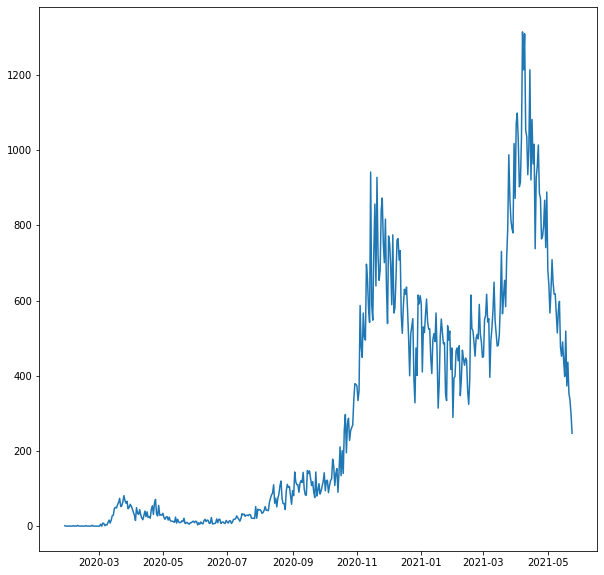

In [17]:
plt.figure(figsize=(10,10))
plt.plot(data)
plt.show()

# **Forcasting using SARIMAX, or Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model**

In [18]:
startDate = '2020-11-01'
data = data.loc[data.index > startDate]
splitDate = '2021-04-01'
train = data.loc[data.index < pd.to_datetime(splitDate)]
test = data.loc[data.index >= pd.to_datetime(splitDate)]
# train.index = pd.DatetimeIndex(train.index).to_period('D')
# test.index = pd.DatetimeIndex(test.index).to_period('D')

In [19]:
print(f'Train {train[:5]},\n Test {test[:5]}')
print(f'Train: {len(train)},\n Test: {len(test)}')

Train Reported Date
2020-11-02    334
2020-11-03    360
2020-11-04    587
2020-11-05    476
2020-11-06    449
Freq: D, Name: Diagnosed, dtype: int64,
 Test Reported Date
2021-04-01    1071
2021-04-02    1099
2021-04-03    1023
2021-04-04     903
2021-04-05     915
Freq: D, Name: Diagnosed, dtype: int64
Train: 150,
 Test: 54


In [20]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1790.073, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1824.327, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1811.462, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1791.639, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1822.491, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1789.519, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1800.642, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1790.960, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1776.742, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1790.670, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1783.548, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1775.7

In [21]:
test.index[-1]

Timestamp('2021-05-24 00:00:00', freq='D')

In [22]:
results = model.fit(train)

In [23]:
autoArimaPrediction = results.predict(n_periods=len(test))

In [24]:
len(test.index), len(autoArimaPrediction)

(54, 54)

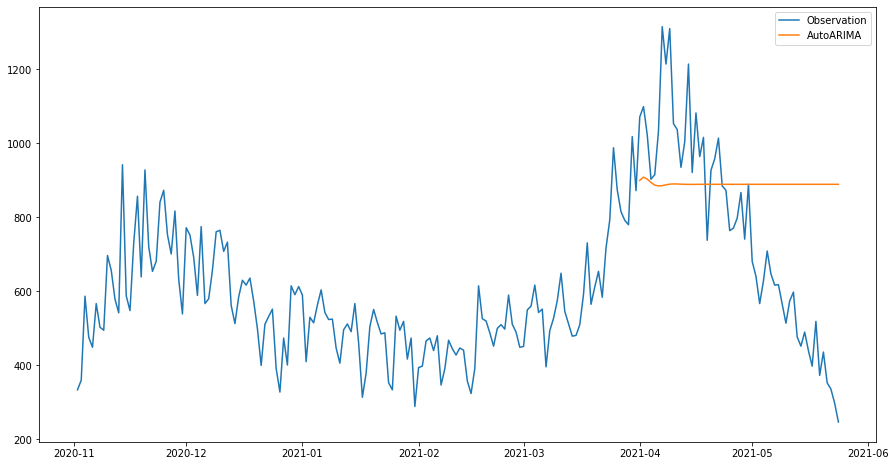

In [25]:
plt.figure(figsize=(15,8))
l1, = plt.plot(data, label='Observation')
l2, = plt.plot(test.index, autoArimaPrediction, label='AutoARIMA')
plt.legend(handles=[l1,l2])
plt.show()

In [26]:
model = SARIMAX(train, order=(3,1,3))

In [27]:
results = model.fit(disp=True)

/home/samjoshva/.pyenv/versions/3.8.1/envs/van_covid19_app/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [28]:
sarimaxPrediction = results.predict(start = splitDate, end = test.index[-1], dynamic=False)

In [29]:
sarimaxPrediction

2021-04-01    959.774774
2021-04-02    909.421504
2021-04-03    849.717783
2021-04-04    811.267500
2021-04-05    824.862108
2021-04-06    879.746036
2021-04-07    934.767672
2021-04-08    948.819938
2021-04-09    911.614876
2021-04-10    851.201568
2021-04-11    812.822882
2021-04-12    825.034283
2021-04-13    878.458803
2021-04-14    932.982855
2021-04-15    947.874309
2021-04-16    912.210358
2021-04-17    852.885605
2021-04-18    814.332081
2021-04-19    825.242237
2021-04-20    877.216758
2021-04-21    931.225882
2021-04-22    946.917376
2021-04-23    912.764199
2021-04-24    854.528894
2021-04-25    815.831862
2021-04-26    825.478979
2021-04-27    876.020010
2021-04-28    929.496797
2021-04-29    945.950179
2021-04-30    913.277484
2021-05-01    856.131782
2021-05-02    817.321573
2021-05-03    825.743350
2021-05-04    874.867764
2021-05-05    927.795760
2021-05-06    944.973710
2021-05-07    913.751291
2021-05-08    857.694626
2021-05-09    818.800588
2021-05-10    826.034214


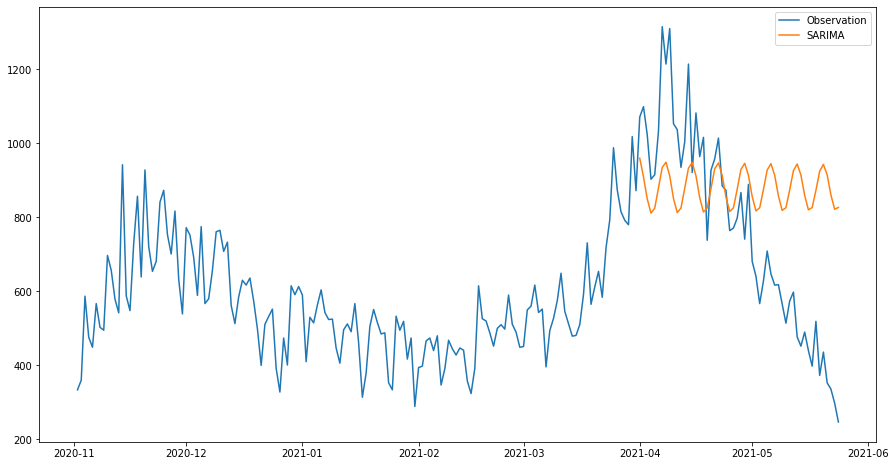

In [30]:
plt.figure(figsize=(15,8))
l1, = plt.plot(data, label='Observation')
l2, = plt.plot(sarimaxPrediction, label='SARIMA')
plt.legend(handles=[l1,l2])

In [31]:
print('SARIMAX MAE = ', mean_absolute_error(sarimaxPrediction, test))

SARIMAX MAE =  238.33344057797927


# **Forcasting using Facebook's Prophet model**

In [32]:
trainDf = pd.DataFrame.from_dict({'ds':train.index, 'y':train})

In [33]:
trainDf.head()

,ds,y
Reported Date,,
2020-11-02,2020-11-02,334
2020-11-03,2020-11-03,360
2020-11-04,2020-11-04,587
2020-11-05,2020-11-05,476
2020-11-06,2020-11-06,449


In [34]:
prophetModel = Prophet(yearly_seasonality=True)
prophetModel.fit(trainDf)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
future = prophetModel.make_future_dataframe(periods=data.shape[0]-train.shape[0])
prophetPrediction = prophetModel.predict(future)

In [36]:
prophetPrediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-11-02,326.342566,238.308370,401.065976,326.342566,326.342566,-7.796916,-7.796916,-7.796916,-83.980431,-83.980431,-83.980431,76.183515,76.183515,76.183515,0.0,0.0,0.0,318.545649
1,2020-11-03,329.724228,368.752140,533.771934,329.724228,329.724228,118.172430,118.172430,118.172430,22.225467,22.225467,22.225467,95.946963,95.946963,95.946963,0.0,0.0,0.0,447.896658
2,2020-11-04,333.105891,432.373611,585.360526,333.105891,333.105891,173.518668,173.518668,173.518668,57.241973,57.241973,57.241973,116.276695,116.276695,116.276695,0.0,0.0,0.0,506.624558
3,2020-11-05,336.487553,445.265484,603.671514,336.487553,336.487553,187.707854,187.707854,187.707854,50.747079,50.747079,50.747079,136.960775,136.960775,136.960775,0.0,0.0,0.0,524.195407
4,2020-11-06,339.869216,429.336728,584.533769,339.869216,339.869216,167.925331,167.925331,167.925331,10.144711,10.144711,10.144711,157.780620,157.780620,157.780620,0.0,0.0,0.0,507.794546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2021-05-20,999.293406,1025.122410,1181.602494,999.293396,999.293418,107.393364,107.393364,107.393364,50.747079,50.747079,50.747079,56.646285,56.646285,56.646285,0.0,0.0,0.0,1106.686770
200,2021-05-21,1002.675069,987.690777,1154.871668,1002.675058,1002.675081,66.688435,66.688435,66.688435,10.144711,10.144711,10.144711,56.543724,56.543724,56.543724,0.0,0.0,0.0,1069.363504
201,2021-05-22,1006.056732,994.131364,1161.122923,1006.056720,1006.056744,72.899330,72.899330,72.899330,17.864863,17.864863,17.864863,55.034467,55.034467,55.034467,0.0,0.0,0.0,1078.956061
202,2021-05-23,1009.438394,911.455315,1066.096167,1009.438383,1009.438407,-22.033822,-22.033822,-22.033822,-74.243662,-74.243662,-74.243662,52.209840,52.209840,52.209840,0.0,0.0,0.0,987.404572


In [37]:
prophetPrediction = prophetPrediction.set_index('ds')
prophetFuture = prophetPrediction.yhat.loc[prophetPrediction.index >= splitDate]
print('Prophet MAE =', mean_absolute_error(prophetFuture, test))

Prophet MAE = 244.1513920074842


In [38]:
prophetFuture

ds
2021-04-01    1008.378209
2021-04-02     988.096298
2021-04-03    1013.860845
2021-04-04     937.302706
2021-04-05     940.448338
2021-04-06    1056.742699
2021-04-07    1098.978834
2021-04-08    1096.812791
2021-04-09    1057.680239
2021-04-10    1064.096139
2021-04-11     968.045830
2021-04-12     951.915041
2021-04-13    1049.504834
2021-04-14    1073.953244
2021-04-15    1055.242502
2021-04-16    1001.108359
2021-04-17     994.333059
2021-04-18     887.130488
2021-04-19     862.071146
2021-04-20     953.093079
2021-04-21     973.420631
2021-04-22     953.069961
2021-04-23     899.757906
2021-04-24     896.195724
2021-04-25     794.476237
2021-04-26     777.001960
2021-04-27     877.500276
2021-04-28     908.947409
2021-04-29     901.080008
2021-04-30     861.310763
2021-05-01     872.029435
2021-05-02     784.997615
2021-05-03     782.284628
2021-05-04     897.290444
2021-05-05     942.677153
2021-05-06     947.887643
2021-05-07     920.067730
2021-05-08     941.372955
2021-05-0

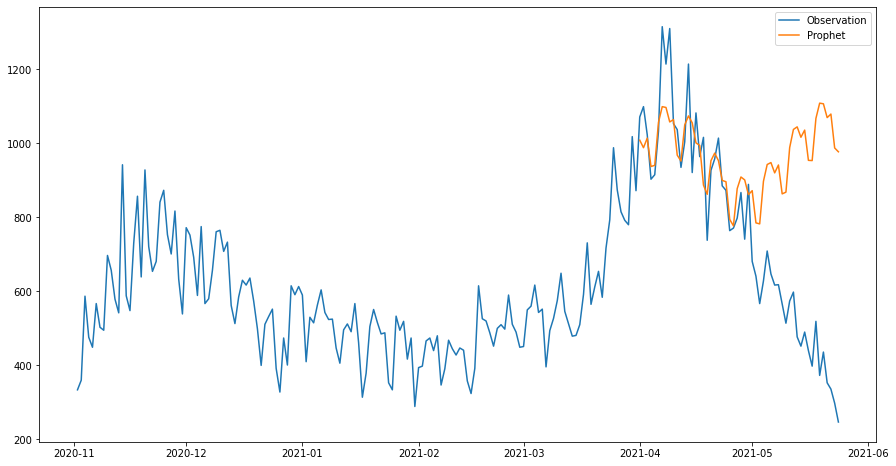

In [39]:
plt.figure(figsize=(15,8))
l1, = plt.plot(data, label='Observation')
l2, = plt.plot(prophetFuture, label='Prophet')
plt.legend(handles=[l1,l2])
plt.show()

# Preparing the dataset for XGBOOST and NN

Unlike the prophet and SAIMAX models, the two models we will train in Task 6, namely XGBOOST and NN, are supervised machine learning models that deal with independent data points, or examples. It assumes that each data point is totally independent from the rest of the data points in the dataset.

Here is a method that extracts these features from a given dataframe object.

In [40]:
data=pd.DataFrame(data)

In [41]:
data.head()

,Diagnosed
Reported Date,
2020-11-02,334
2020-11-03,360
2020-11-04,587
2020-11-05,476
2020-11-06,449


In [42]:
def featurize(t):
    X = pd.DataFrame()
    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    y = t.Diagnosed
    return X, y

featurize(data)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,2,11,4,0,307,45
1,3,11,4,1,308,45
2,4,11,4,2,309,45
3,5,11,4,3,310,45
4,6,11,4,4,311,45


# Create training and test datasets by splitting the dataset, and perform data normalization.

In this task we are going to cover two topics in data preparation: splitting the dataset into training and test data, and normalizing the data.

You might have already performed a splitting operation of a dataset in machine learning, where one takes a randomly selected portion of the dataset, say 20%, as a test set, while the remaining 80% is the training set. It is randomly selected because the whole dataset is randomly shufflled before the selection. Another popular approach is the k-fold cross validation.

However, those two methods won't work with time series data. The reason is: when we train the model on the training set, the purpose is to predict the target values in the future, which corresponds to date values that are outside of the date values in the training set.

In [43]:
X_train, y_train = featurize(
data.loc[data.index < pd.to_datetime(splitDate)])
X_test, y_test = featurize(
data.loc[data.index >= pd.to_datetime(splitDate)])



In [44]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [45]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

# Train the XGBOOST and NN models

First, create the XGBRegressor object which will represent the XGBOOST regression model.

In [46]:
XGModel = XGBRegressor(n_estimators = 7)

Next, train the XGBOOST regression model using the fit method, and perform prediction using the predict method.

In [47]:
XGModel.fit(scaled_train, y_train,
           eval_set=[(scaled_train, y_train), (scaled_test, y_test)],
           verbose=True)
XGPredictions =  XGModel.predict(scaled_test)

[0]	validation_0-rmse:417.47748	validation_1-rmse:630.78522
[1]	validation_0-rmse:304.04608	validation_1-rmse:514.96613
[2]	validation_0-rmse:223.42348	validation_1-rmse:448.23721
[3]	validation_0-rmse:166.31364	validation_1-rmse:370.59070
[4]	validation_0-rmse:125.47315	validation_1-rmse:343.23401
[5]	validation_0-rmse:96.74113	validation_1-rmse:327.82578
[6]	validation_0-rmse:76.58263	validation_1-rmse:318.62024


Let us calculate the mean absolute error for the training.

In [48]:
print('XGModel MAE = ', mean_absolute_error(XGPredictions, y_test))

XGModel MAE =  259.9784692834925


Creation and training of the feedforward neural network model.

In [49]:
opt = adam_v2.Adam(learning_rate=0.001)
NNModel = Sequential()
NNModel.add(Dense(20, input_shape=(scaled_train.shape[1],)))
NNModel.add(Dense(10))
NNModel.add(Dense(1))
NNModel.compile(loss='mean_absolute_error', optimizer=opt)
NNModel.fit(scaled_train, y_train, validation_data=(
scaled_test, y_test), epochs=220, verbose=1)
NNModelPrediction = NNModel.predict(scaled_test) 

Epoch 1/220
5/5 [==============================] - 10s 65ms/step - loss: 571.8372 - val_loss: 768.7789
Epoch 2/220
5/5 [==============================] - 0s 4ms/step - loss: 573.1855 - val_loss: 768.7368
Epoch 3/220
5/5 [==============================] - 0s 4ms/step - loss: 561.5244 - val_loss: 768.6879
Epoch 4/220
5/5 [==============================] - 0s 4ms/step - loss: 566.8148 - val_loss: 768.6484
Epoch 5/220
5/5 [==============================] - 0s 4ms/step - loss: 558.6570 - val_loss: 768.6060
Epoch 6/220
5/5 [==============================] - 0s 4ms/step - loss: 556.8227 - val_loss: 768.5590
Epoch 7/220
5/5 [==============================] - 0s 4ms/step - loss: 556.9054 - val_loss: 768.5129
Epoch 8/220
5/5 [==============================] - 0s 4ms/step - loss: 579.2591 - val_loss: 768.4634
Epoch 9/220
5/5 [==============================] - 0s 3ms/step - loss: 554.8102 - val_loss: 768.4026
Epoch 10/220
5/5 [==============================] - 0s 4ms/step - loss: 557.6536 - val_lo

Let's compare the MAE values.

In [50]:
print('XGBOOST MAE =', mean_absolute_error(XGPredictions, y_test))
print('Prophet MAE =', mean_absolute_error(prophetFuture, test))
print('SARIMAX MAE =', mean_absolute_error(sarimaxPrediction, test))
print('NN MAE =', mean_absolute_error(NNModelPrediction, test))

XGBOOST MAE = 259.9784692834925
Prophet MAE = 244.1513920074842
SARIMAX MAE = 238.33344057797927
NN MAE = 304.53782032154226


Finally let us visualize the predictions of all 4 models. Note the autofmt_xdate method in matplotlib, it knows how to appropriately rotate the date labels on the x-axis.

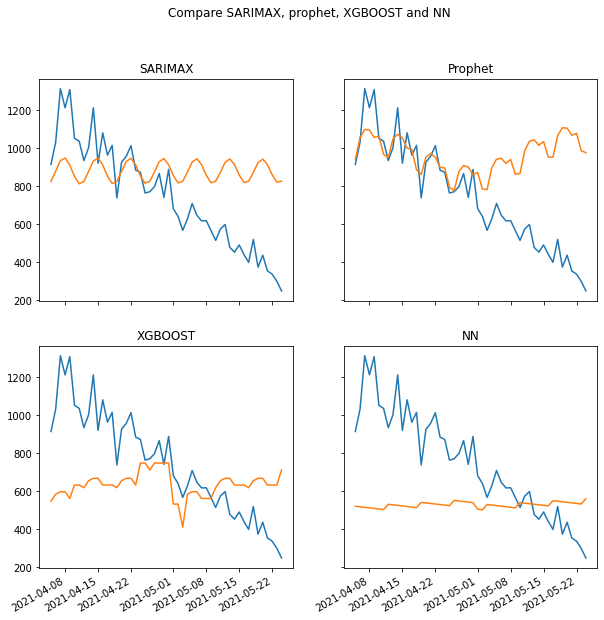

In [51]:

XGDf = pd.DataFrame({'y': XGPredictions.tolist()})
XGDf.index = y_test.index

NNdf = pd.DataFrame(NNModelPrediction)
NNdf.index = y_test.index

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(data.tail(50))
axs[0, 0].plot(sarimaxPrediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(data.tail(50))
axs[0, 1].plot(prophetFuture.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(data.tail(50))
axs[1, 0].plot(XGDf.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(data.tail(50))
axs[1, 1].plot(NNdf.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)

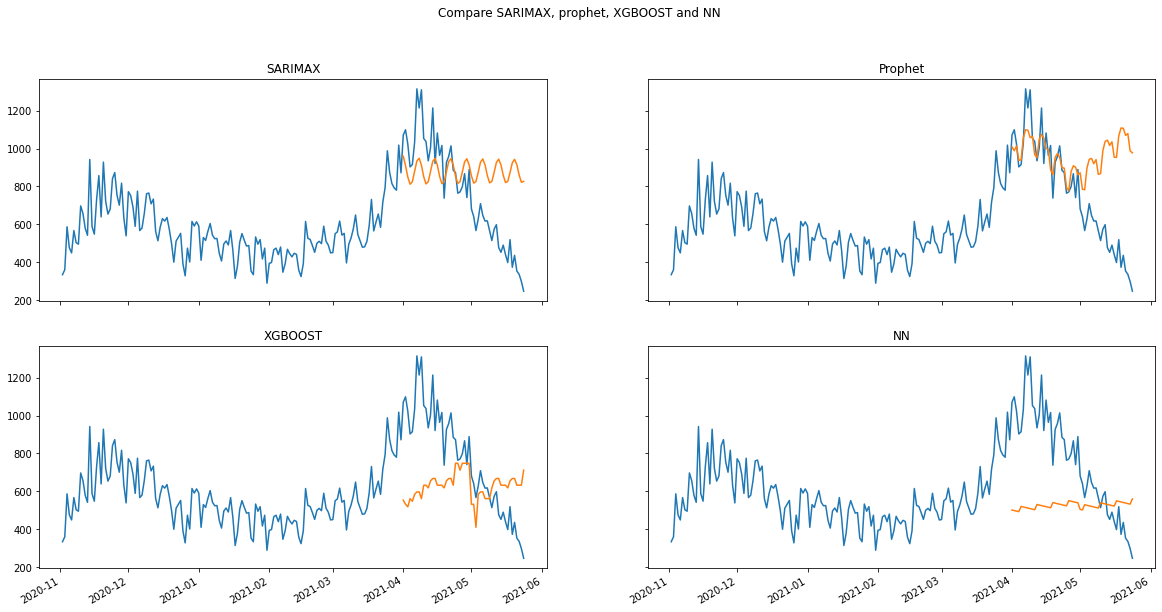

In [52]:

XGDf = pd.DataFrame({'y': XGPredictions.tolist()})
XGDf.index = y_test.index

NNdf = pd.DataFrame(NNModelPrediction)
NNdf.index = y_test.index

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(data)
axs[0, 0].plot(sarimaxPrediction)
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(data)
axs[0, 1].plot(prophetFuture)
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(data)
axs[1, 0].plot(XGDf)
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(data)
axs[1, 1].plot(NNdf)
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)